In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [2]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gigab\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1


In [4]:
Train_df = 'C:/Users/gigab/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training'
filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)


100%|██████████| 1457/1457 [00:00<?, ?it/s]


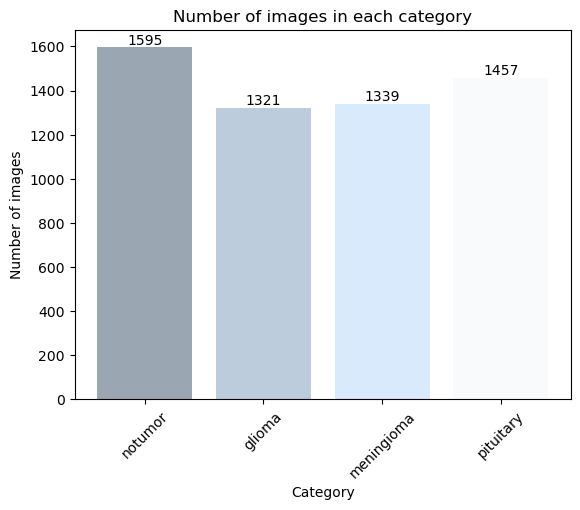

In [5]:
# Correcting the labeling issue in the bar graph for swapped categories
color = ['#9AA6B2', '#BCCCDC', '#D9EAFD', '#F8FAFC']

df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)
# Reorder labels for the graph so that 'pituitary' and 'glioma' are swapped visually
correct_order = ['notumor', 'glioma', 'meningioma', 'pituitary']

df_train['label'] = pd.Categorical(df_train['label'], categories=correct_order, ordered=True)
df_train_sorted = df_train.sort_values('label')

fig, ax = plt.subplots()
bars = ax.bar(correct_order, df_train['label'].value_counts()[correct_order], color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [6]:
Test_df = 'C:/Users/gigab/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing'


filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)


100%|██████████| 300/300 [00:00<00:00, 297538.71it/s]


In [7]:
df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

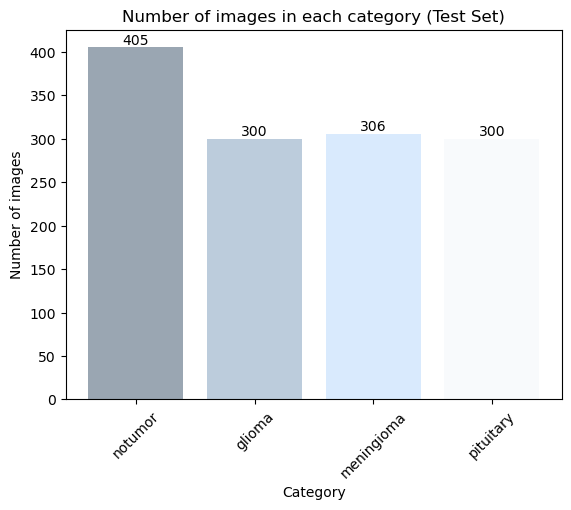

In [8]:
df_test['label'].value_counts()
color = ['#9AA6B2', '#BCCCDC', '#D9EAFD', '#F8FAFC']

correct_order = ['notumor', 'glioma', 'meningioma', 'pituitary']

df_test['label'] = pd.Categorical(df_test['label'], categories=correct_order, ordered=True)
df_test_sorted = df_test.sort_values('label')

fig, ax = plt.subplots()
bars = ax.bar(correct_order, df_test['label'].value_counts()[correct_order], color=color)
ax.bar_label(bars)
plt.title('Number of images in each category (Test Set)')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [9]:
valid_ts, df_test = train_test_split(df_test, test_size=0.3, random_state=42)

In [10]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')


Found 5712 validated image filenames belonging to 4 classes.
Found 917 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


In [11]:
class_dict = gen_train.class_indices


In [12]:
Model = Sequential([
    Conv2D(64, kernel_size= (3,3), activation='relu', input_shape=(img_size[0],img_size[1],3)),
    Conv2D(64, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3), activation='relu'),
    Conv2D(128, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(265, kernel_size= (3,3), activation='relu'),
    Conv2D(265, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3), activation='relu'),
    Conv2D(512, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3), activation='relu'),
    Conv2D(512, kernel_size= (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0,3),
    Dense(4, activation='softmax') ])


In [13]:
Model.compile(optimizer=
              
              Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = Model.fit(
    gen_train,
    epochs=16,
    validation_data=gen_valid,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 870s 5s/step - accuracy: 0.3378 - loss: 1.2628 - val_accuracy: 0.6903 - val_loss: 0.7918
Epoch 2/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 876s 5s/step - accuracy: 0.7573 - loss: 0.6189 - val_accuracy: 0.7786 - val_loss: 0.5594
Epoch 3/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 867s 5s/step - accuracy: 0.8248 - loss: 0.4618 - val_accuracy: 0.7983 - val_loss: 0.5053
Epoch 4/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 861s 5s/step - accuracy: 0.8639 - loss: 0.3760 - val_accuracy: 0.8342 - val_loss: 0.4527
Epoch 5/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.8978 - loss: 0.3040 - val_accuracy: 0.8593 - val_loss: 0.3428
Epoch 6/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 855s 5s/step - accuracy: 0.9187 - loss: 0.2094 - val_accuracy: 0.8768 - val_loss: 0.2924
Epoch 7/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 857s 5s/step - accuracy: 0.9316 - loss: 0.1836 - val_accuracy: 0.9019 - val_loss: 0.2831
Epoch 8/16
179/179 ━━━━━━━━━━━━━━━━━━━━ 866s 5s/step - accuracy: 0.9410 - loss: 0.1594 - val_accu

In [75]:
print(Model.evaluate(gen_train))
print(Model.evaluate(gen_valid))
print(Model.evaluate(gen_test))


179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 963ms/step - accuracy: 0.9939 - loss: 0.0258
[0.027024250477552414, 0.9940476417541504]
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 947ms/step - accuracy: 0.9713 - loss: 0.1050
[0.09814317524433136, 0.9629225730895996]
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 915ms/step - accuracy: 0.9614 - loss: 0.1233
[0.09729226678609848, 0.9670050740242004]


In [16]:
Model.save('Model m.h5')


In [17]:
preds = Model.predict(gen_test)
y_pred = np.argmax(preds, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 906ms/step


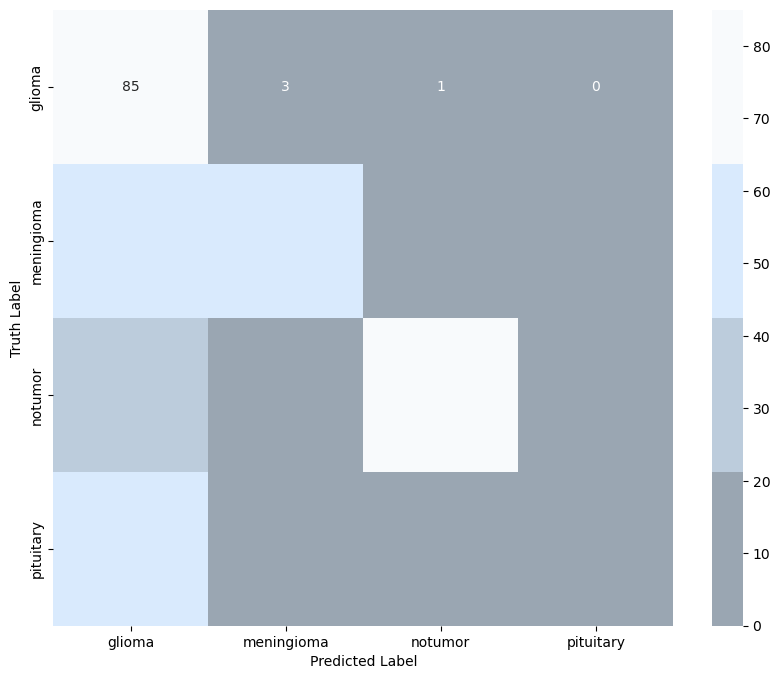

In [73]:
cm = confusion_matrix(gen_test.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

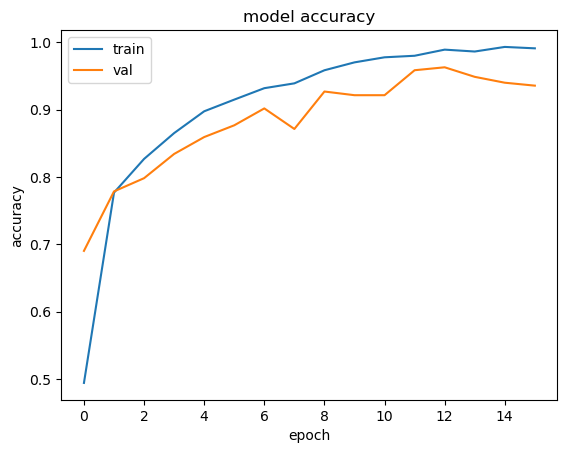

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

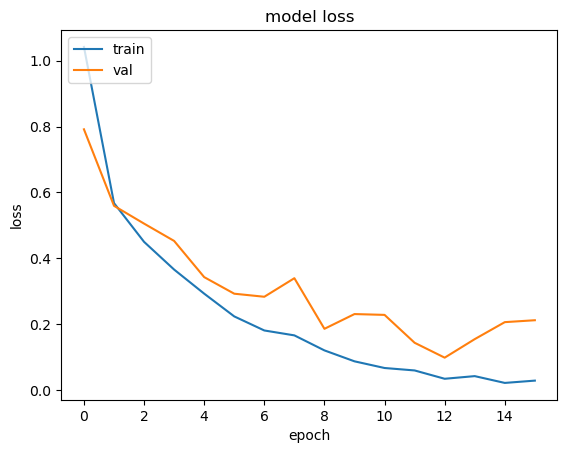

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [21]:
def predict(img_path):

    
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = Model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


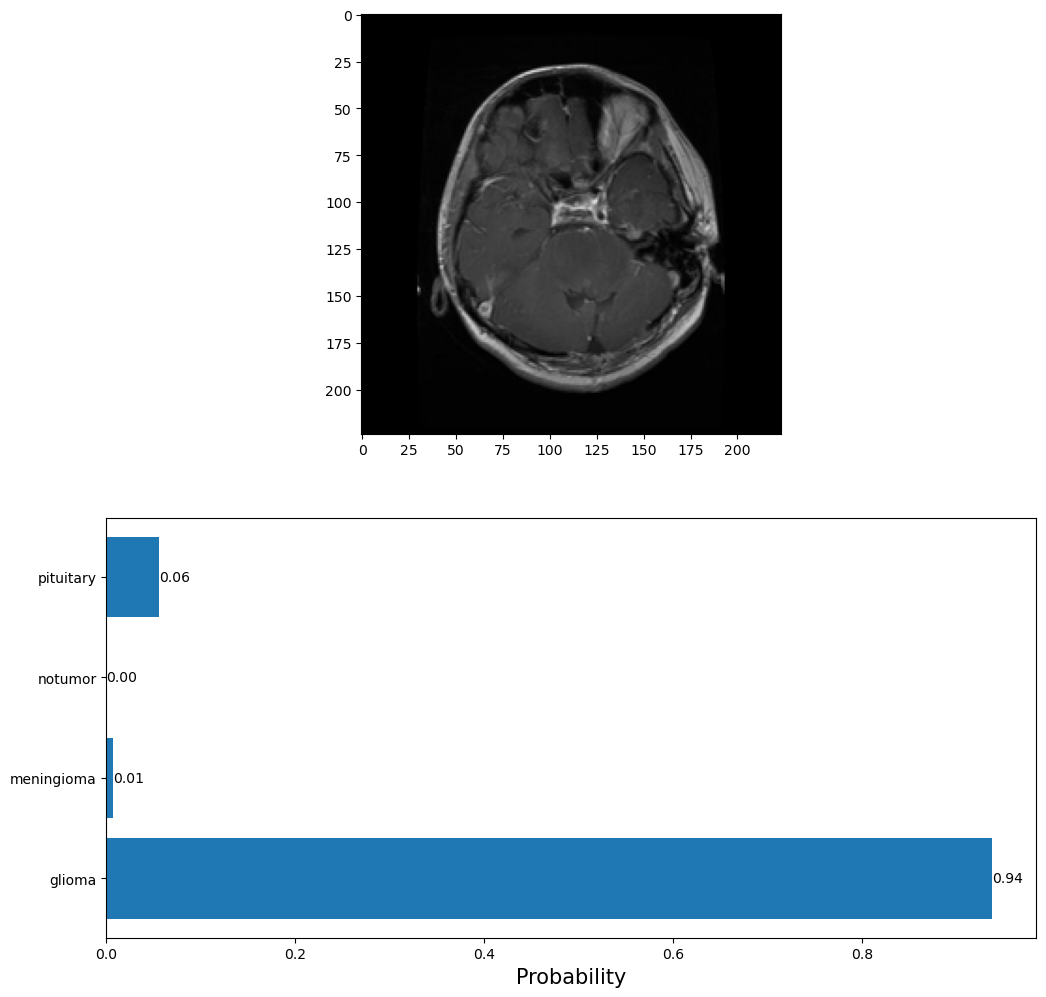

In [22]:
predict('C:/Users/gigab/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0010.jpg')




In [23]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size[0],img_size[1],3),
    pooling='max',
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 52s 1us/step


In [24]:
ModelPretrained = Sequential([
    base_model,
    
    Dense(256 , activation='relu'),
    Dropout(0,3),
    Dense(4, activation='softmax')
    
])
ModelPretrained.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history_Final = ModelPretrained.fit(
    gen_train, 
    epochs=5, 
    validation_data=gen_valid, 
    verbose=1, 
    
)


Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 967s 5s/step - accuracy: 0.7621 - loss: 1.5518 - val_accuracy: 0.2203 - val_loss: 1.5295
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 903s 5s/step - accuracy: 0.9628 - loss: 0.1129 - val_accuracy: 0.3828 - val_loss: 1.5317
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 912s 5s/step - accuracy: 0.9899 - loss: 0.0388 - val_accuracy: 0.4417 - val_loss: 1.5792
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 907s 5s/step - accuracy: 0.9810 - loss: 0.0484 - val_accuracy: 0.3206 - val_loss: 15.4139
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 904s 5s/step - accuracy: 0.9960 - loss: 0.0139 - val_accuracy: 0.6020 - val_loss: 1.1922


In [26]:
train_score = ModelPretrained.evaluate(gen_train, verbose=1)
valid_score = ModelPretrained.evaluate(gen_valid, verbose=1)
test_score = ModelPretrained.evaluate(gen_test, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 761ms/step - accuracy: 0.5635 - loss: 1.2490
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 747ms/step - accuracy: 0.5890 - loss: 1.1967
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 719ms/step - accuracy: 0.6094 - loss: 1.0752 
Train Loss: 1.2562
Train Accuracy: 56.74%
--------------------
Validation Loss: 1.1922
Validation Accuracy: 60.20%
--------------------
Test Loss: 1.1398
Test Accuracy: 58.88%


In [27]:
ModelPretrained.save('DeepBrain.h5')

In [83]:
preds = ModelPretrained.predict(gen_test)
y_pred = np.argmax(preds, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 717ms/step 


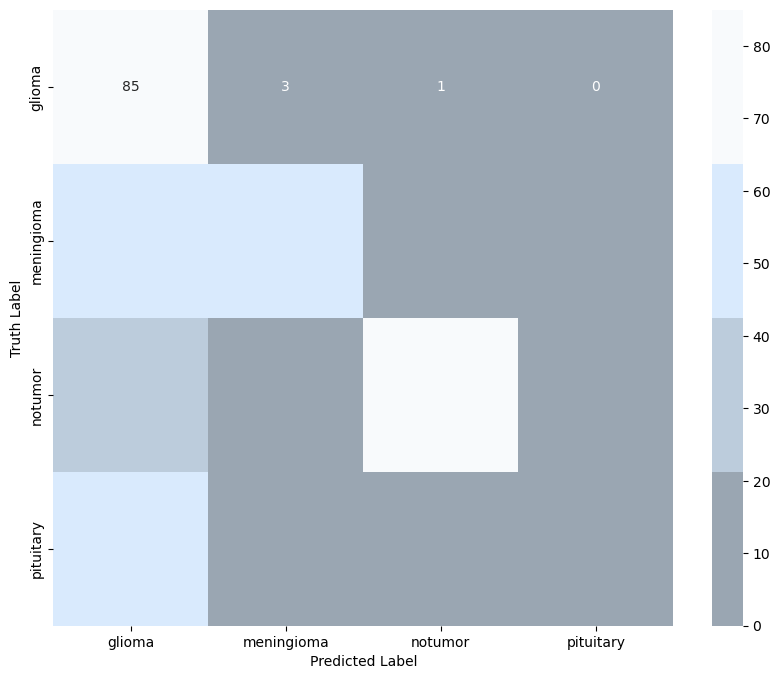

In [85]:
cm = confusion_matrix(gen_test.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

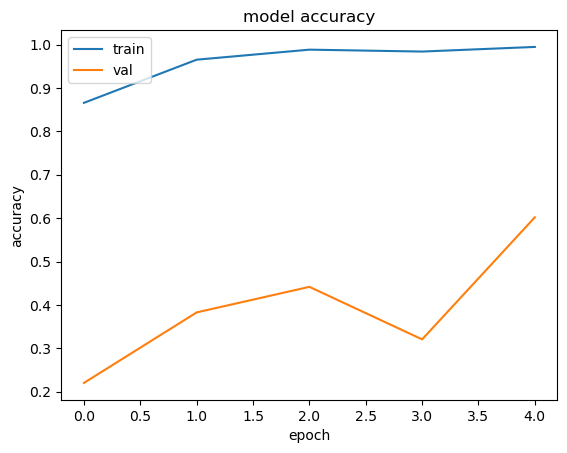

In [30]:
plt.plot(history_Final.history['accuracy'])
plt.plot(history_Final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


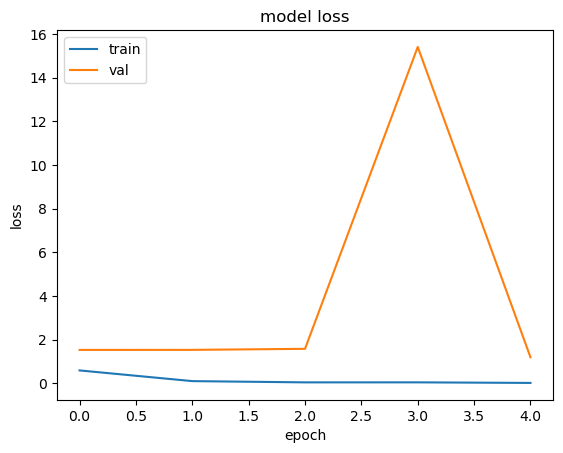

In [31]:
plt.plot(history_Final.history['loss'])
plt.plot(history_Final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [32]:
def predict(img_path):

    
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = ModelPretrained.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


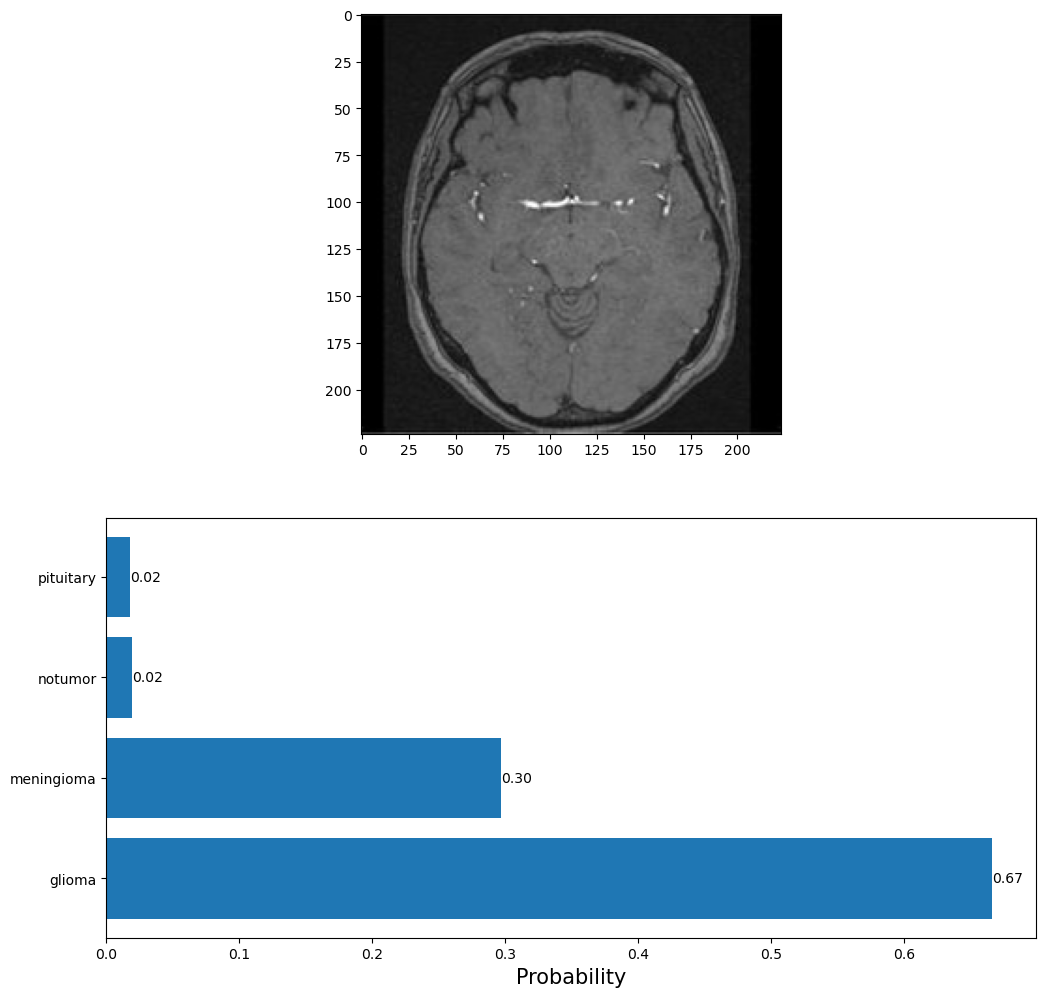

In [77]:
predict('C:/Users/gigab/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/notumor/Te-no_0017.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


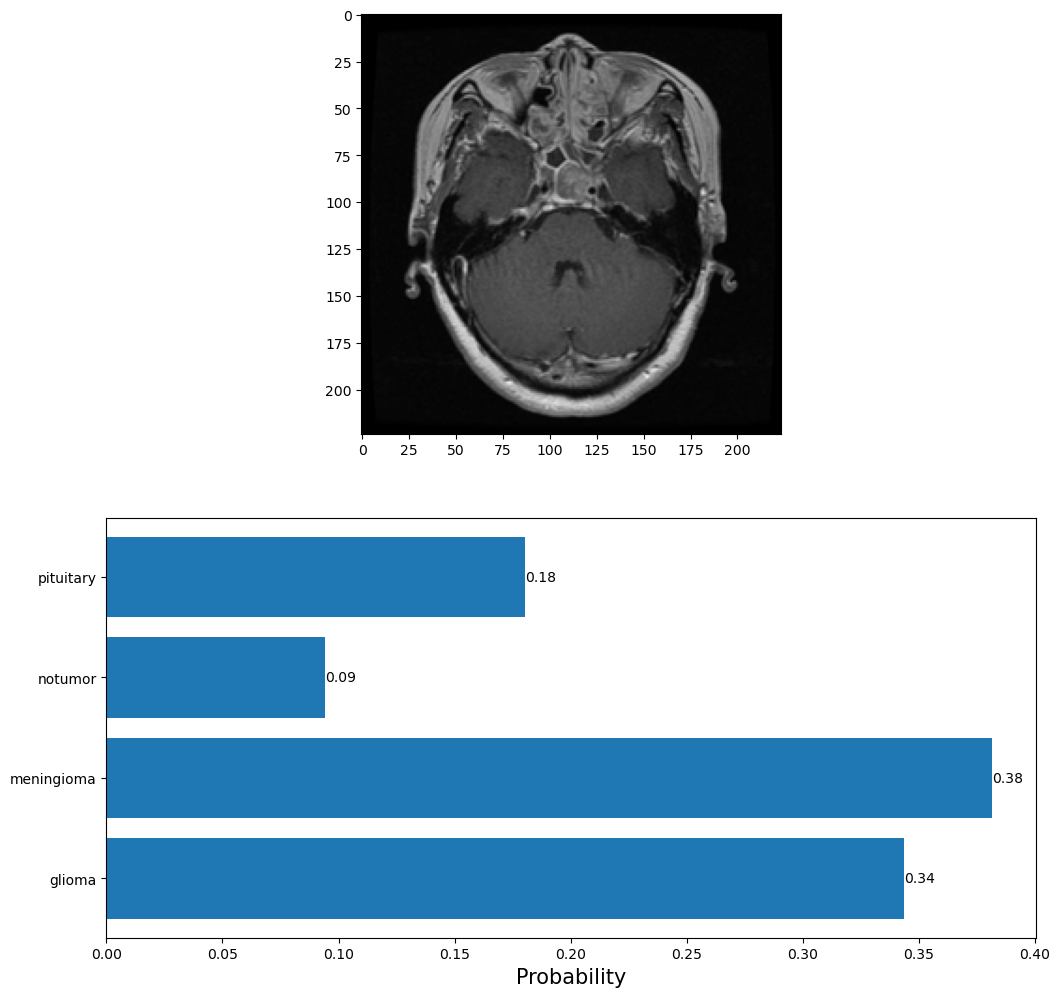

In [79]:
predict('C:/Users/gigab/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/pituitary/Te-pi_0059.jpg')